#  Measuring Prompt Reliance — Project Setup

Our project studies **how much attention a language model gives** to different parts of a conversation.  
We model this as three “voices” the system hears at once:

- **( P )**: *System prompt* — instructions like “be polite” or “summarize.”  
- **( Q )**: *User query* — the actual question or command.  
- **( S )**: *Self-context* — the model’s own previous output.  

We will measure, for each model layer, what fraction of its total attention mass  
is directed toward **( P )**, **( Q )**, and **( S )**.

Mathematically, we define normalized attention shares:

$$
\text{PAM} = \frac{\sum \text{Attn}_{P}}{\sum \text{Attn}_{P,Q,S}}, \quad
\text{QAM} = \frac{\sum \text{Attn}_{Q}}{\sum \text{Attn}_{P,Q,S}}, \quad
\text{SAM} = \frac{\sum \text{Attn}_{S}}{\sum \text{Attn}_{P,Q,S}}
$$



## Step 1 — Installing Dependencies

We install the libraries needed for our analysis:

- **PyTorch** for compute  
- **Transformers** for pretrained LMs  
- **Datasets** for loading Alpaca/FLAN/ShareGPT later  
- **Matplotlib** for plots  
- **Einops/TQDM** for tensor ops & progress

Colab resets runtimes, so keeping this cell at the top makes the notebook reproducible.


In [58]:
pip -q install "torch==2.3.1" "transformers==4.44.2" "accelerate>=0.33" "datasets>=2.20" "einops>=0.7" "tqdm" "matplotlib"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 555.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 86.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 828.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

##  Step 2 — Verifying the Environment

We confirm versions and GPU availability to ensure attention extraction will run efficiently.


In [1]:
import torch, torchvision, torchaudio, transformers, datasets, numpy as np
print("torch:", torch.__version__)
print("torchvision:", torchvision.__version__)
print("torchaudio:", torchaudio.__version__)
print("transformers:", transformers.__version__)
print("numpy:", np.__version__)
print("CUDA available:", torch.cuda.is_available())



torch: 2.8.0+cu126
torchvision: 0.23.0+cu126
torchaudio: 2.8.0+cu126
transformers: 4.57.1
numpy: 2.0.2
CUDA available: True


##  Step 3 — Loading a Small Language Model

We load a compact instruction-tuned model (TinyLlama 1.1B) and enable attention outputs with `output_attentions=True`,  
so the model returns attention tensors $(L, H, T, S)$: layers, heads, target positions, source positions.

If you are on CPU, we’ll fall back to a tiny model to keep things fast.



In [10]:
!pip -q install -U "bitsandbytes>=0.45.0"


In [12]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
PRIMARY_MODEL = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"   # GPU
FALLBACK_MODEL = "sshleifer/tiny-gpt2"                 # CPU
model_id = PRIMARY_MODEL if device=="cuda" else FALLBACK_MODEL

tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    output_attentions=True,
    dtype=torch.float16 if device=="cuda" else torch.float32,  # <-- no bnb here
)
model.to(device).eval()

print(f"Loaded {model_id} on {device} (no 8-bit).")


model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Loaded TinyLlama/TinyLlama-1.1B-Chat-v1.0 on cuda (no 8-bit).


##  Step 4 — Defining the Input Structure

Each example is a triplet:
\[
(P, Q, S) = (\text{system prompt},\, \text{user prompt},\, \text{assistant prefix})
\]
We will wrap these into a small data class and build a tagged string:
`<P>…</P>`, `<Q>…</Q>`, `<A>…`.


In [13]:
from dataclasses import dataclass

@dataclass
class Triplet:
    system: str
    user: str
    assistant_prefix: str = ""

def build_prompt(t: Triplet) -> str:
    return f"<P>{t.system}</P>\n<Q>{t.user}</Q>\n<A>{t.assistant_prefix}"


##  Step 6 — Tokenization and Segment Boundaries

We convert the combined text into tokens and compute token spans:

\[
\begin{aligned}
\text{Span}(P) &= [i_P^{\text{start}},\, i_P^{\text{end}}] \\
\text{Span}(Q) &= [i_Q^{\text{start}},\, i_Q^{\text{end}}] \\
\text{Span}(S) &= [i_S^{\text{start}},\, i_S^{\text{end}}]
\end{aligned}
\]

These spans let us aggregate attention by **source segment**.


In [14]:
def tokenize_with_segments(t: Triplet, tokenizer):
    text = build_prompt(t)
    enc = tokenizer(text, return_tensors="pt", add_special_tokens=False)
    input_ids = enc["input_ids"][0]

    # Character spans of inner content
    s = text
    p_start = s.index("<P>") + 3
    p_end   = s.index("</P>")
    q_start = s.index("<Q>") + 3
    q_end   = s.index("</Q>")
    a_start = s.index("<A>") + 3
    a_end   = len(s)

    # Map char spans -> token spans (simple heuristic via cumulative decode)
    toks = [tokenizer.decode([tid], skip_special_tokens=True) for tid in input_ids.tolist()]
    def char_to_token_span(char_lo, char_hi):
        cum, start_tok, end_tok = 0, None, None
        for i, tk in enumerate(toks):
            nxt = cum + len(tk)
            if start_tok is None and nxt > char_lo:
                start_tok = i
            if end_tok is None and nxt >= char_hi:
                end_tok = i
                break
            cum = nxt
        if start_tok is None: start_tok = 0
        if end_tok   is None: end_tok   = len(toks)-1
        return (start_tok, end_tok)

    spans = {
        "P": char_to_token_span(p_start, p_end),
        "Q": char_to_token_span(q_start, q_end),
        "S": char_to_token_span(a_start, a_end),
    }
    return enc, spans, text


##  Step 6 — Forward Pass and Attention Extraction

We run a forward pass and retrieve attention tensors:
$[
\text{attn}[l] \in \mathbb{R}^{H \times T \times S}
$]
for each layer \( l \), heads \( H \), target positions \( T \), and source positions \( S \).


In [15]:
import torch

@torch.no_grad()
def forward_with_attn(input_ids):
    out = model(input_ids=input_ids.to(device), output_attentions=True, use_cache=False)
    # out.attentions is a tuple length L; each item is [batch, heads, T, S]
    return out.logits, out.attentions


##  Step 7 — Computing PAM, QAM, SAM

We define the normalized attention shares per layer:
$[
\text{PAM}_l = \frac{\sum_{h,t} A_{h,t,P}}{\sum_{h,t,s} A_{h,t,s}},\quad
\text{QAM}_l = \frac{\sum_{h,t} A_{h,t,Q}}{\sum_{h,t,s} A_{h,t,s}},\quad
\text{SAM}_l = \frac{\sum_{h,t} A_{h,t,S}}{\sum_{h,t,s} A_{h,t,s}}
$]
and average across layers to get overall shares.


In [16]:
import numpy as np

def segment_mask(src_len, span, device):
    m = torch.zeros(src_len, dtype=torch.bool, device=device)
    s, e = span
    m[s:(e+1)] = True
    return m

def compute_shares(attn_tuple, spans):
    L = len(attn_tuple)
    pam, qam, sam = [], [], []
    for l in range(L):
        A = attn_tuple[l][0]  # [H, T, S]  (batch=1)
        A = torch.clamp(A, min=0.0)
        A = A / (A.sum(dim=-1, keepdim=True) + 1e-9)

        Slen = A.shape[-1]
        Pmask = segment_mask(Slen, spans["P"], A.device)
        Qmask = segment_mask(Slen, spans["Q"], A.device)
        Smask = segment_mask(Slen, spans["S"], A.device)

        P_share = A[..., Pmask].sum(dim=-1).mean().item()
        Q_share = A[..., Qmask].sum(dim=-1).mean().item()
        S_share = A[..., Smask].sum(dim=-1).mean().item()

        pam.append(P_share); qam.append(Q_share); sam.append(S_share)

    return {
        "PAM_per_layer": pam,
        "QAM_per_layer": qam,
        "SAM_per_layer": sam,
        "PAM": float(np.mean(pam)),
        "QAM": float(np.mean(qam)),
        "SAM": float(np.mean(sam)),
    }


##  Step 8 — Sanity-Check Example

We test the full pipeline on a simple prompt and inspect the resulting attention shares:
$((\text{PAM}, \text{QAM}, \text{SAM})$).


In [17]:
sample = Triplet(
    system="You are a helpful, concise assistant. Use short bullet points.",
    user="Explain gravity to a 10-year-old.",
    assistant_prefix=""
)

enc, spans, _ = tokenize_with_segments(sample, tokenizer)
logits, attentions = forward_with_attn(enc["input_ids"])
shares = compute_shares(attentions, spans)

print("PAM/QAM/SAM (avg over layers):",
      round(shares["PAM"],3), round(shares["QAM"],3), round(shares["SAM"],3))
print("Spans (token indices):", spans)


PAM/QAM/SAM (avg over layers): 0.289 0.075 1.0
Spans (token indices): {'P': (3, 23), 'Q': (25, 41), 'S': (0, 41)}


##  Step 9 — Visualizing Attention by Layer

We plot per-layer shares to see how focus shifts across depth:
$[
l \mapsto (\text{PAM}_l,\, \text{QAM}_l,\, \text{SAM}_l).
$]


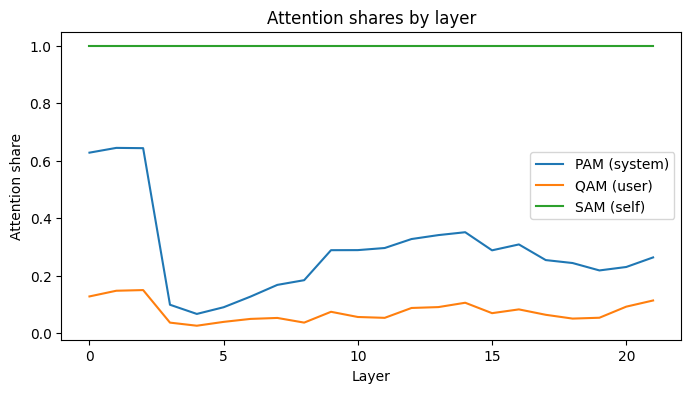

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def plot_layer_shares(shares_dict):
    L = len(shares_dict["PAM_per_layer"])
    x = np.arange(L)
    plt.figure(figsize=(8,4))
    plt.plot(x, shares_dict["PAM_per_layer"], label="PAM (system)")
    plt.plot(x, shares_dict["QAM_per_layer"], label="QAM (user)")
    plt.plot(x, shares_dict["SAM_per_layer"], label="SAM (self)")
    plt.xlabel("Layer"); plt.ylabel("Attention share")
    plt.title("Attention shares by layer")
    plt.legend(); plt.show()

plot_layer_shares(shares)


…the model has very few self-context tokens (S) (basically none yet), so that segment dominates trivially (the green line at 1.0).
That’s expected, because the denominator (sum over P, Q, S) normalizes per segment, and if S covers nearly all positions, the attention mass collapses there.

In [20]:
sample = Triplet(
    system="You are a helpful assistant. Write short bullet points.",
    user="Explain gravity to a 10-year-old.",
    assistant_prefix="Gravity is the force that pulls things toward each other."
)


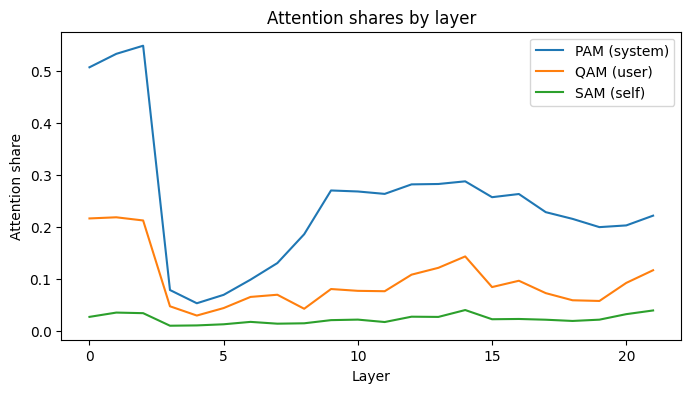

In [21]:
enc, spans, _ = tokenize_with_segments(sample, tokenizer)
_, attn = forward_with_attn(enc["input_ids"])
shares = compute_shares(attn, spans)
plot_layer_shares(shares)


##  Why the Green Line Is Lower Now

Think of the model like a student paying attention to three things:

1.  **System prompt** $P$: what the teacher told it — “Be polite,” “Summarize,” etc.  
2.  **User query** $Q$: the question on the test — “Explain gravity to a 10-year-old.”  
3.  **Self-context** $S$: the model’s own notes — the answer it’s already written.

---

###  What Happened Before

When the model had no real answer yet (the *assistant prefix* was empty),  
it had almost nothing to look at except itself.  
So all its attention went to its own “notes.”  



$$
\text{Total attention} = \text{Attn}_P + \text{Attn}_Q + \text{Attn}_S
$$

but when $\text{Attn}_P \approx 0$ and $\text{Attn}_Q \approx 0$,  
then $\text{Attn}_S \approx 1.0$.  
That’s why the **green line (SAM)** was high before.

---

###  What Happened Now

Now that we gave the model an actual answer prefix — real words in $S$ —  
it started *sharing its focus* between the teacher’s instructions and the question too.  

$$
\text{Attn}_P + \text{Attn}_Q + \text{Attn}_S = 1
$$

When $\text{Attn}_P$ and $\text{Attn}_Q$ increase,  
$\text{Attn}_S$ must go down.  

So the green line becomes **lower** —  
not because the model forgot about itself,  
but because it’s finally *listening* to everyone else.

---



Now
The green line went down because attention got balanced.  
That’s a **good** sign — it means the model is learning to pay attention to the prompt and question,  
not just its own words.


## Persist Results to Google Drive

Colab resets runtimes. Mount Drive so datasets, results, and figures persist.


In [19]:
from google.colab import drive
drive.mount('/content/drive')

import json, os, pathlib
PROJECT_DIR = "/content/drive/MyDrive/prompt-reliance-attention"
pathlib.Path(PROJECT_DIR).mkdir(parents=True, exist_ok=True)

with open(os.path.join(PROJECT_DIR, "sanity_results.json"), "w") as f:
    json.dump({"shares": shares}, f, indent=2)

print("Saved to:", os.path.join(PROJECT_DIR, "sanity_results.json"))


Mounted at /content/drive
Saved to: /content/drive/MyDrive/prompt-reliance-attention/sanity_results.json
